In [196]:
#%reload_ext autoreload
#%autoreload 2
from algae_app.models import *
from django.db.models import Q, Sum, Count
import pandas as pd
from django.utils import timezone
from django.core.files import File
import cv2
import uuid
import numpy as np
import os

In [197]:
fname=os.path.join('media','data','AG-RW-CM51-5805.xlsx')
df=pd.read_excel(io=fname,sheetname=1)
df.drop(inplace=True, axis=1, labels=df.columns[10]) #time
df.drop(inplace=True, axis=1, labels=df.columns[:3]) #place Group original_date
for i in [0,1,2,4,5,6]: #first 6 columns
    col=df.columns[i]
    df[df.columns[i]].replace('-', np.nan, inplace=True)
    df.dropna(inplace=True, axis=0, subset=[col])
df.head()

,date,time,Turbidity (NTU.),pH,Conductivity (umho/cm),DO (mgl),OC (mg/l),Cyclotella sp.,Aulocoseria sp.,Melosira granulata (Aulocoseria granulata),...,Synedra ulna,Anabaena sp.,Lyngbya sp.,Oscillatoria sp.,Chlorella sp.,Closterium sp.,Filter Algae,Taste&Odor Algae,Polution Algae,Total Algae
93,2012-01-18,10.35,31.2,8.35,238,3.35,3.32,0,720,0,...,80,80,0,1040,0,480,2400,160,5440,6960
94,2012-02-02,9.33,25.6,7.87,207,4.60,2.45,880,1240,0,...,240,0,0,560,880,240,3800,240,2560,5800
95,2012-02-08,9.48,24.4,7.9,230,4.24,2.61,2560,1680,0,...,240,0,0,1520,800,160,7440,240,4720,11440
96,2012-03-05,9.25,22.9,7.76,203,5.46,2.37,1680,1200,0,...,0,0,0,1360,400,160,6880,160,3440,10880
97,2012-03-15,10.01,19.3,7.72,206,5.08,1.82,720,800,0,...,240,0,0,2560,1840,240,6560,240,6240,9040


In [198]:
for i in df[1:].iterrows():
    df.set_value(index=i[0],col="date",value=i[1]["date"].replace(hour=int(i[1]["time"])))

In [199]:
df.shape

(164, 24)

In [200]:
df.drop(axis=1,labels="time",inplace=True)
df.replace('-', 0,inplace=True)
df.replace(r'\s+', np.nan,inplace=True,regex=True)
df.fillna(inplace=True, method="ffill")
df

,date,Turbidity (NTU.),pH,Conductivity (umho/cm),DO (mgl),OC (mg/l),Cyclotella sp.,Aulocoseria sp.,Melosira granulata (Aulocoseria granulata),Nitzschia sp.,...,Synedra ulna,Anabaena sp.,Lyngbya sp.,Oscillatoria sp.,Chlorella sp.,Closterium sp.,Filter Algae,Taste&Odor Algae,Polution Algae,Total Algae
93,2012-01-18 00:00:00,31.20,8.35,238.0,3.35,3.32,0,720,0,480,...,80,80,0,1040,0,480,2400,160,5440,6960
94,2012-02-02 09:00:00,25.60,7.87,207.0,4.60,2.45,880,1240,0,240,...,240,0,0,560,880,240,3800,240,2560,5800
95,2012-02-08 09:00:00,24.40,7.90,230.0,4.24,2.61,2560,1680,0,80,...,240,0,0,1520,800,160,7440,240,4720,11440
96,2012-03-05 09:00:00,22.90,7.76,203.0,5.46,2.37,1680,1200,0,160,...,0,0,0,1360,400,160,6880,160,3440,10880
97,2012-03-15 10:00:00,19.30,7.72,206.0,5.08,1.82,720,800,0,320,...,240,0,0,2560,1840,240,6560,240,6240,9040
98,2012-03-23 11:00:00,16.60,7.68,222.0,5.06,2.21,480,1120,0,160,...,0,0,0,2960,2000,160,7360,0,8400,11520
99,2012-03-29 10:00:00,18.20,7.53,232.0,4.10,2.37,160,80,0,800,...,0,0,0,1560,720,0,2760,0,3800,4520
100,2012-04-03 10:00:00,22.20,7.54,255.0,3.35,2.84,0,0,0,1360,...,0,160,0,2240,4720,320,7440,160,8800,9840
101,2012-04-10 09:00:00,20.60,7.58,275.0,3.45,2.84,40,80,0,400,...,0,0,0,1440,480,80,2280,0,2560,2920
102,2012-04-18 11:00:00,19.50,7.58,305.0,3.54,4.00,2600,12200,0,800,...,200,0,0,3200,1000,200,19200,200,5000,21400


In [201]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [202]:
df.columns

Index([u'date', u'Turbidity \n(NTU.)', u'pH', u'Conductivity \n(umho/cm)',
       u'DO \n(mgl)', u'OC \n(mg/l)', u'Cyclotella sp.', u'Aulocoseria sp.',
       u'Melosira granulata\n(Aulocoseria granulata)', u'Nitzschia sp.',
       u'Nitzschia palae', u'Skeletonema sp.', u'Synedra acus',
       u'Synedra ulna', u'Anabaena sp.', u'Lyngbya sp.', u'Oscillatoria sp.',
       u'Chlorella sp.', u'Closterium sp.', u'Filter Algae',
       u'Taste&Odor Algae', u'Polution Algae', u'Total Algae'],
      dtype='object')

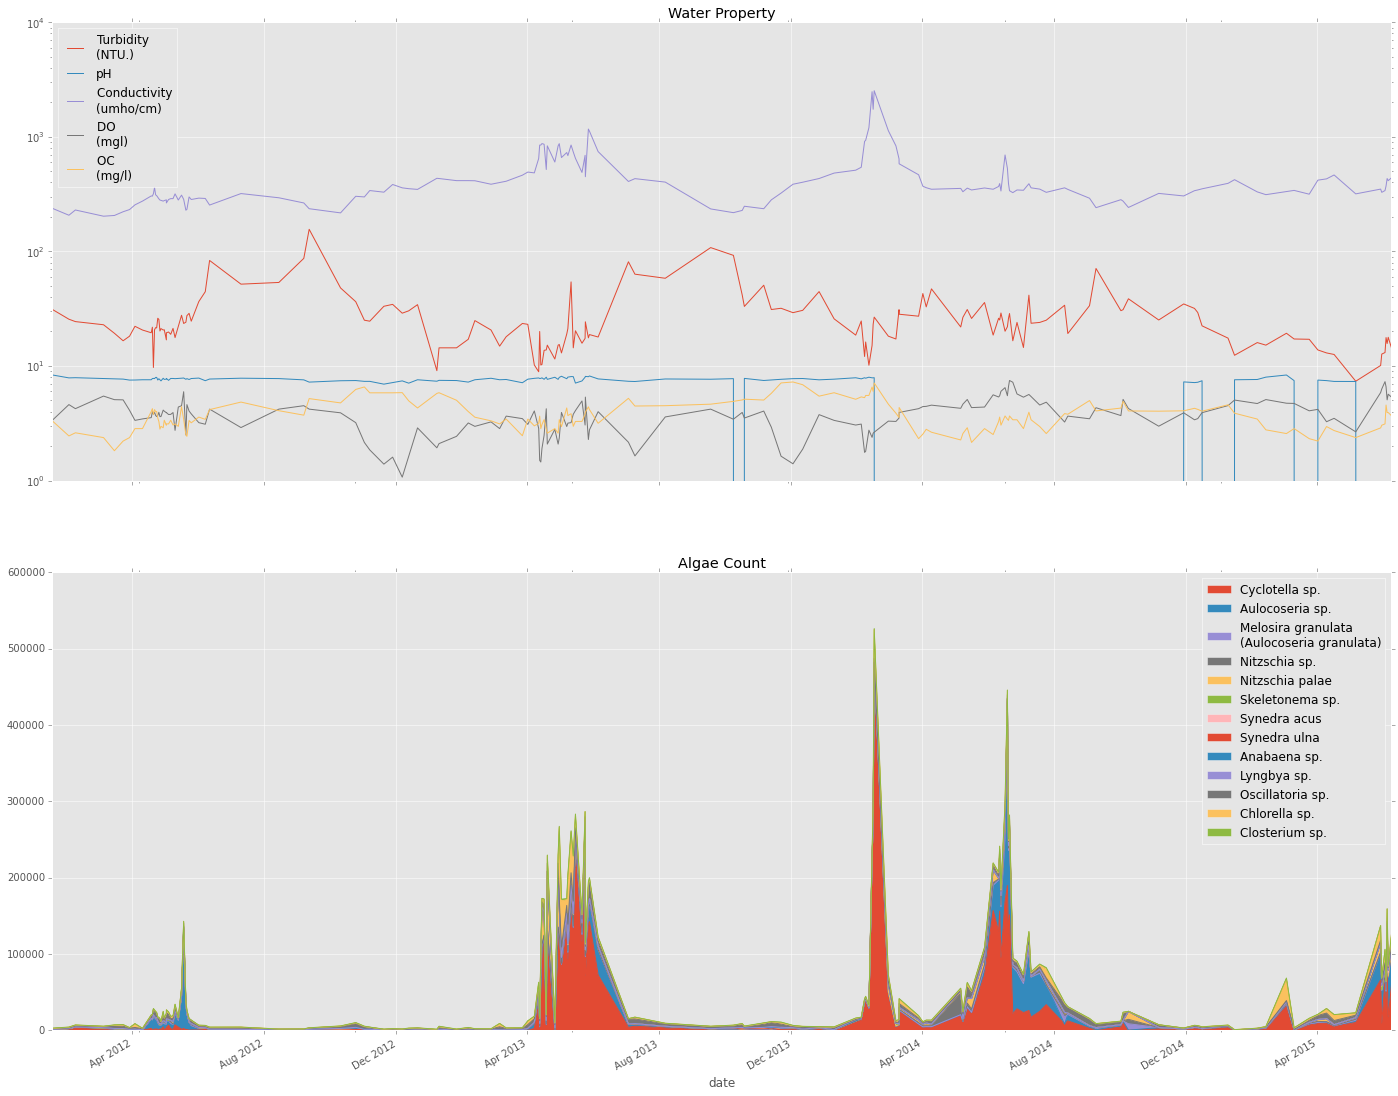

In [203]:
##water
df_water=df[df.columns[0:6]]
ax1 = plt.subplot(211)
ax1.set_title('Water Property')
df_water.plot(x='date', ax=ax1)
plt.yscale('log')
plt.setp(ax1.get_xticklabels(), fontsize=12)

##algae
algae_columns=df.columns[6:19].insert(0,df.columns[0])
df_water=df[algae_columns]
ax2 = plt.subplot(212, sharex=ax1)
ax2.set_title('Algae Count')
df_water.plot.area(x='date', ax=ax2)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(24,20)
fname=os.path.join('media','graph','graph.png')
fig.savefig(fname, dpi=100, bbox_inches='tight')

In [204]:
algae_columns

Index([u'date', u'Cyclotella sp.', u'Aulocoseria sp.',
       u'Melosira granulata\n(Aulocoseria granulata)', u'Nitzschia sp.',
       u'Nitzschia palae', u'Skeletonema sp.', u'Synedra acus',
       u'Synedra ulna', u'Anabaena sp.', u'Lyngbya sp.', u'Oscillatoria sp.',
       u'Chlorella sp.', u'Closterium sp.'],
      dtype='object')